In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data data-week-3.csv

--2025-09-17 09:15:59--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.8’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-09-17 09:15:59 (7.79 MB/s) - ‘course_lead_scoring.csv.8’ saved [80876/80876]

--2025-09-17 09:15:59--  http://data-week-3.csv/
Resolving data-week-3.csv (data-week-3.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘data-week-3.csv’
FINISHED --2025-09-17 09:15:59--
Total wall clock time: 0.08s
Downloaded: 1 files, 79K in 0.01s (7.79 MB/s)


In [4]:
df = pd.read_csv(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data preparation

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [7]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [8]:
numerical_columns = [col for col in df.dtypes[df.dtypes != 'object'].index 
                     if col != "converted"]

In [9]:
df[categorical_columns] = df[categorical_columns].fillna('NA')

In [10]:
df[numerical_columns] = df[numerical_columns].fillna(0.0)

In [11]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

# Question 1

In [12]:
df['industry'].mode()[0]

'retail'

# Question 2

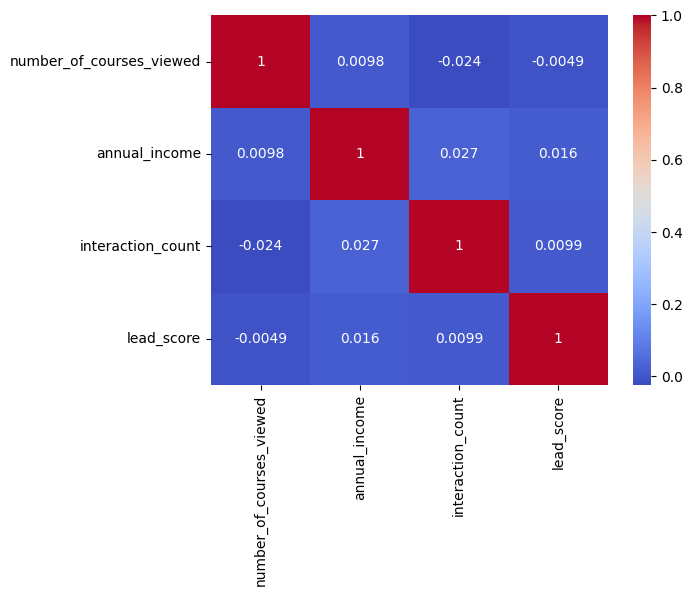

In [13]:
corr_matrix = df[numerical_columns].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

# Split the data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [16]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Question 3

In [19]:
from sklearn.metrics import mutual_info_score, accuracy_score

In [20]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.converted)

In [21]:
df_full_train[categorical_columns].apply(mutual_info_churn_score).sort_values(ascending=False)

lead_source          0.025665
employment_status    0.013258
industry             0.011685
location             0.002253
dtype: float64

# Question 4

In [22]:
from sklearn.feature_extraction import DictVectorizer

In [23]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [24]:
dv.get_feature_names_out()

array(['annual_income', 'employment_status=NA',
       'employment_status=employed', 'employment_status=self_employed',
       'employment_status=student', 'employment_status=unemployed',
       'industry=NA', 'industry=education', 'industry=finance',
       'industry=healthcare', 'industry=manufacturing', 'industry=other',
       'industry=retail', 'industry=technology', 'interaction_count',
       'lead_score', 'lead_source=NA', 'lead_source=events',
       'lead_source=organic_search', 'lead_source=paid_ads',
       'lead_source=referral', 'lead_source=social_media', 'location=NA',
       'location=africa', 'location=asia', 'location=australia',
       'location=europe', 'location=middle_east',
       'location=north_america', 'location=south_america',
       'number_of_courses_viewed'], dtype=object)

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [27]:
model.intercept_[0]

np.float64(-0.0691472802783609)

In [28]:
model.coef_[0].round(3)

array([-0.   , -0.015,  0.034,  0.003,  0.012, -0.103, -0.025,  0.049,
       -0.02 , -0.013, -0.003, -0.009, -0.032, -0.016,  0.311,  0.051,
        0.02 , -0.012, -0.012, -0.115,  0.08 , -0.03 ,  0.004, -0.011,
       -0.011, -0.006,  0.008,  0.006, -0.033, -0.025,  0.454])

In [29]:
y_pred = model.predict(X_val)

In [30]:
accuracy = accuracy_score(y_val, y_pred)

In [31]:
accuracy

0.6996587030716723

# Question 5

In [32]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)

In [33]:
accuracy

0.6996587030716723

In [34]:
categorical_numerical = categorical_columns + numerical_columns
res = {}
for col in categorical_numerical:
    # drop one column at a time
    train_dict = (
        df_train[categorical_numerical]
        .drop(columns=[col])
        .to_dict(orient="records")
    )

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)

    val_dict = (
        df_val[categorical_numerical]
        .drop(columns=[col])
        .to_dict(orient="records")
    )
    
    X_val = dv.transform(val_dict)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    res.update({col: accuracy})

In [35]:
dict(sorted(res.items()))

{'annual_income': 0.8532423208191127,
 'employment_status': 0.6962457337883959,
 'industry': 0.6996587030716723,
 'interaction_count': 0.5563139931740614,
 'lead_score': 0.7064846416382252,
 'lead_source': 0.7030716723549488,
 'location': 0.7098976109215017,
 'number_of_courses_viewed': 0.5563139931740614}

In [36]:
diffs = {k: abs(v - accuracy) for k, v in res.items()}

In [37]:
sorted_items = sorted(diffs.items(), key=lambda x: x[1])

In [38]:
print(sorted_items)

[('lead_score', 0.0), ('lead_source', 0.0034129692832763903), ('location', 0.0034129692832765013), ('industry', 0.0068259385665528916), ('employment_status', 0.010238907849829282), ('annual_income', 0.14675767918088745), ('number_of_courses_viewed', 0.15017064846416384), ('interaction_count', 0.15017064846416384)]


# Question 6

In [39]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

regularized = {} 
for C in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    # solver='lbfgs' is the default solver in newer version of sklearn
    # for older versions, you need to specify it explicitly
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)

    regularized.update({C: accuracy})

In [40]:
regularized

{0.01: 0.6996587030716723,
 0.1: 0.6996587030716723,
 1: 0.6996587030716723,
 10: 0.6996587030716723,
 100: 0.6996587030716723}